# Stability, Consistency, Stiffness

## Stability
* All stability analysis considered here is for linear ODEs.
    * If we have a nonlinear ODE, then we will first linearize it, and then analyse its stability.

A finite difference solution of an ODE is stable if it produces a bounded solution for a stable ODE. 

<img src="https://ignite.byu.edu/che541/lectures/figs/l15f01.png" width="400">

### Explicit Euler

* Consider the linear ODE $$y^{\prime} = -\alpha y + F(t)$$
    * If the ODE is homogeneous then $F(t) = 0$. 
        * Stability is independent of $F(t)$.
* Take $\alpha$ to be strictly positive. We can enforce this if we like by replacing $\alpha$ with $\alpha^2$ since $\alpha$ is just a constant.
    * This forces the ODE itself to be bounded, hence stable.
$$y_{n+1} = y_n - \Delta t \alpha y_n,$$
$$\frac{y_{n+1}}{y_n} = 1-\alpha\Delta t,$$




To avoid instability, we need $|y_{n+1}/y_n|\le 1$, so 
$$|1-\alpha\Delta t|\le 1,$$

$$-1\le 1-\alpha\Delta t\le 1.$$

* The second half of this inequality is true for positive $\Delta t$.
* The first half of this inequality gives $-2\le-\alpha\Delta t$ $\rightarrow$ $2\ge \alpha\Delta t$, which gives.

<font color='blue'>
$$\Delta t \le\frac{2}{\alpha}.$$
</font>




* Note, the exact solution is $y=y_0\exp(-\alpha t).$ 
    * So, the characteristic timescale is $\tau = 1/\alpha$ 
    * So, <font color='blue'>$\Delta t_{max} = 2\tau$</font>
    * So, don't take a step that is longer than some factor of the implied physical timescale.

### Implicit Euler
$$y_{n+1} = y_n - \Delta t\alpha y_{n+1},$$

$$\frac{y_{n+1}}{y_n} = \frac{1}{1+\alpha\Delta t} \le 1$$
* This is true for all $\Delta t$.
* So, implicit Euler is <font color="blue">unconditionally stable.</font>


In [111]:
import Plots as plt
using NLsolve

In [112]:
function odeEE(f, y0, t)
    ns = length(t)-1
    y = zeros(ns+1)
    y[1] = y0
    
    for k in 1:ns
        h = t[k+1]-t[k]
        y[k+1] = y[k] + h*f(y[k],t[k])
    end
    
    return y
end

#---------------------------

function odeIE(f, y0, t) 
    ns = length(t) - 1
    y = zeros(ns+1)
    y[1] = y0
    
    function F!(Fval, ynext)
        Fval[1] = ynext[1] - y[kk] - Δt*f(ynext[1], t[kk+1])
    end
    
    kk=undef
    Δt=undef
    for k in 1:ns
        kk = k
        Δt = t[k+1]-t[k]
        results = nlsolve(F!, [y[k]])
        y[k+1] = results.zero[1]
    end
    
    return y
end;

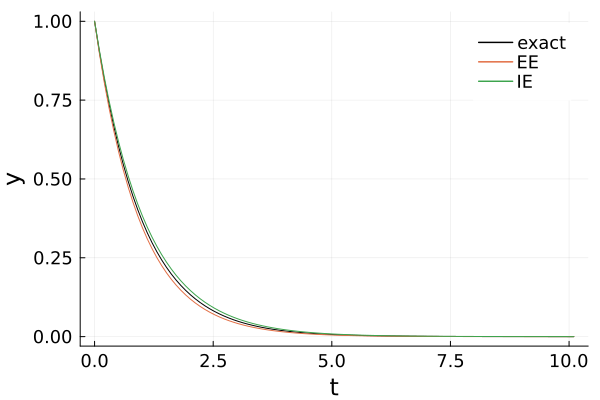

In [113]:
f(y,t) = (α=1; -α*y)

#---------------------------

y0 = 1
tend = 10
Δt = 0.1
t = LinRange(0.0, tend+Δt, trunc(Int, tend/Δt+1))

yex = y0*exp.(-t)
yee = odeEE(f, y0, t)
yie = odeIE(f, y0, t)

#---------------------------

plt.resetfontsizes(); plt.scalefontsizes(1.5)
plt.plot( t,yex, lw=1, label="exact", color="black")
plt.plot!(t,yee, lw=1, label="EE")
plt.plot!(t,yie, lw=1, label="IE")
plt.plot!(xlabel="t", ylabel="y")
plt.plot!(foreground_color_legend=nothing)

### Multi-dimensional system of ODEs
$$\frac{d\vec{y}}{dt} = \vec{F}(\vec{y}).$$
* Let $\vec{F}({\vec{y}})$ be arbitrary (nonlinear).
* Linearize (and drop the arrow notation for simplicity):
$$\frac{dy}{dt} = F(y_n) + [J]_n(\Delta y)_n.$$
* Here, $J$ is the Jacobian and $\Delta y=y-y_n$.


* Take $dy= d(y-y_n)$, where $y_n$ is a constant. Then
$$\frac{d\Delta y_n}{dt} = J\Delta y_n + F_n.$$
$$J = V\Lambda V^{-1}.$$
$$\frac{d\Delta y_n}{dt} = V\Lambda V^{-1}\Delta y_n + F_n.$$
* Multiply by $V^{-1}$ and let $V^{-1}\Delta y_n = \hat{\Delta y}_n$, and $V^{-1}F_n = \hat{F}_n$.

$$\frac{d\hat{\Delta y}_n}{dt} = \Lambda \hat{\Delta y}_n + \hat{F}_n.$$



* This is a decoupled linear system with component $i$ given by
$$\frac{d\hat{\Delta y}_{i,n}}{dt} = \Lambda_i \hat{\Delta y}_{i,n} + \hat{F}_{i,n}.$$
* $\Lambda_i$ is like $-\alpha$ before.
* So $\Lambda_i$ should be negative for positive $\alpha$:

<font color='blue'>
$$\Delta t \le -\frac{2}{\Lambda_{i,max}}.$$
</font>

## Consistency

* All numerical solutions to ODEs should recover the original ODE when the stepsize approaches zero.
* This is called *consistency*, and a *consistent* ODE has this property.
* Approach:
    * Take the finite difference equation (the numerical method for the ODE).
    * Turn it into an ODE. This results in the so called **modified differential equation** or MDE.
    * Evaluate this as $\Delta t\rightarrow 0$.
* This is less important for methods derived directly from Taylor series.
* This becomes more important when we discuss PDEs, and especially their character in terms of extra terms in the MDE.


### Explicit Euler
* For ODE $y^{\prime} = f(y)$, with $\Delta t = h$, the finite difference equation (FDE) for EE is
$$y_{n+1} = y_n + hf_n.$$



* Convert the FDE to an ODE:
    * Take a Taylor series for the terms in the FDE:
    $$ y_{n+1} = y_n + hy^{\prime} + \frac{h^2}{2}y^{\prime\prime} + \ldots.$$
    * Insert this into the FDE:
    $$ y_n + hy^{\prime} + \frac{h^2}{2}y^{\prime\prime} + \ldots = y_n + hf_n.$$
    * The $y_n$ terms on each side cancel. Solve for $y^{\prime}$:
    $$y^{\prime} = \frac{1}{h}\left(hf_n - \frac{h^2}{2}y^{\prime\prime} - \ldots.\right)$$
    <font color='blue'>
    $$y^{\prime} = f_n - \left[\frac{h}{2}y^{\prime\prime} - \ldots\right].$$
    </font>

* Again:
<font color='blue'>
$$y^{\prime} = f_n - \left[\frac{h}{2}y^{\prime\prime} - \ldots\right].$$
</font>

* As $h\rightarrow 0$, the term in bracket $\rightarrow 0$ and we recover the ODE. 
    * So EE is consistent.
* **Note, the blue equation above is called the MDE. When we solve EE, it is like we are really solving the MDE instead of the original ODE.**
    * The term in brackets is the error term and is responsible for differences between our real ODE and the MDE, and hence differences in our solution $y(t)$.

## Stiff ODEs
* An ODE is stiff if the step size required for stability is much smaller than the step size required for accuracy.
* An ODE is stiff if it contains some componenets of the solution that decay rapidly compared to other components of the system.
* A system of ODEs is stiff if at least one eigenvalue of the system is negative and large compared to the other eigenvalues of the system.
* From a practical point of view, an ODE is stiff if the step size based on cost (i.e., the computational time) is too large to obtain an accurate (i.e., stable) solution.

### Example
$$\frac{dy}{dt} = f(y,t) = -\alpha(y-F(t)) + F^{\prime}(t).$$

* The exact solution is 

$$y=(y_0 - F(0))e^{-\alpha t} + F(t).$$

* Now, take $y_0=0$, $\alpha = 1000$ and $F(t) = t+2.$

$$y(t) = -2e^{-1000t} + t + 2.$$

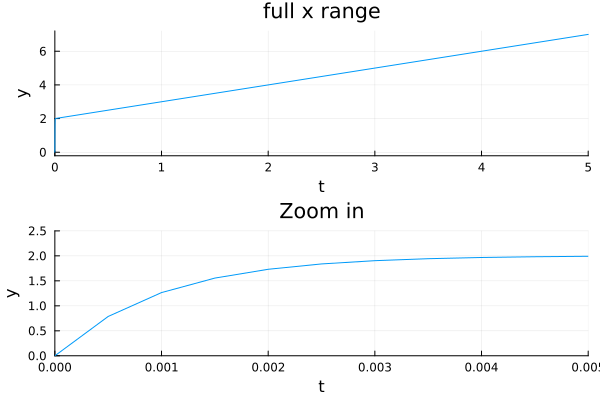

In [55]:
t = LinRange(0,5,10000)
y = -2*exp.(-1000*t) + t .+ 2;

plt.resetfontsizes()
plots=[]
plt.plot(t,y)
plt.plot!(xlim=[0,5])
p=plt.plot!(ylabel="y", xlabel="t", legend=nothing)
plt.plot!(title="full x range")
push!(plots,p)
plt.plot(t,y)
plt.plot!(xlim=[0,0.005], ylim=[0,2.5])
plt.plot!(title="Zoom in")
p=plt.plot!(ylabel="y", xlabel="t", legend=nothing)
push!(plots,p)
plt.plot(plots..., layout=(2,1))

* Note how the above plot *appears* to be dominated by the $t+2$ term. It is practically linear over the whole domain. 
* But if you zoom in on the beginning, you can see a fast transient.


#### Solve with Explicit Euler

In [57]:
f(y,t) = (α=100; -α*(y-t-2.0) + 1.0)

y0   = 0            # try with 0 and 2
tend = 4.5

tEX  = LinRange(0,tend,10000)
yEX = -2*exp.(-100*tEX) + tEX .+ 2;

n steps = 249


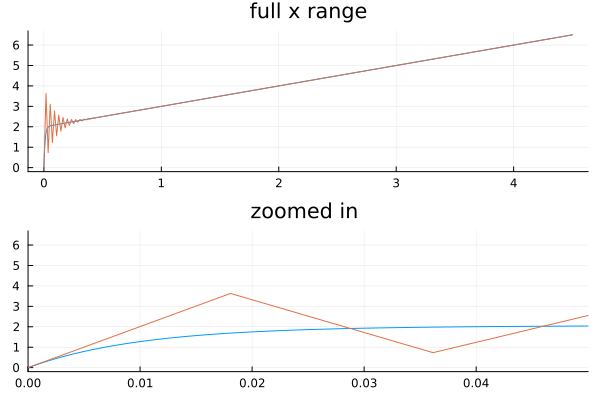

In [105]:
fac = 0.9                # try values: 0.1, 0.5, 0.9, 1.1
dt  = 2.0/100*fac        # 2/alpha is the stability limit, * a factor to adjust up or down
t   = LinRange(0,tend,trunc(Int,tend/dt+1))

yEE = odeEE(f, y0, t)

#----------------------

println("n steps = $(length(t)-1)")

plt.plot(tEX,yEX); 
p1 = plt.plot!(t,yEE, legend=nothing, title="full x range")

plt.plot(tEX,yEX); 
plt.plot!(t,yEE)
p2 = plt.plot!(xlim=[0, 0.05], legend=nothing, title="zoomed in ")

plt.plot([p1,p2]..., layout=(2,1))


* **For EE, the stepsize is dictated by the smallest timescale, *even if that timescale is unimportant to most of the solution.***
* This may require **much** smaller timesteps for stability than is required for accuracy. 
* This is generally not an acceptable approach.


#### What can be done?


* Use an implicit method, or
* Explicitly remove the stiffness (change the equation).
    * In kinetics, we do this when we invoke steady state or partial equilibrium approximations. 
    * Steady state approximation: "in many chemical systems of interest, highly reactive intermediate species (e.g., radicals) are formed. After a rapid initial buildup in concentration, the radical is destroyed as rapidly as it is formed, so that its rate of formation and its rate of destruction are equal." (Turns, and Introduction to Combustion).
    * Partial equilibrium approximation: treat reactions with fast forward and backward rates as if they were in equilibrium.
    * Both of these methods remove fast timescales through "analytic" algebraic expressions.
    

#### Solve with Implicit Euler

n steps = 22


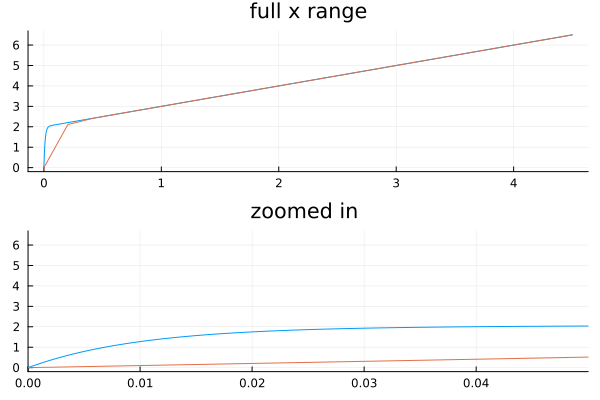

In [110]:
fac = 10                 # try values: 0.1, 0.5, 0.9, 1.1, 10
dt = 2.0/100*fac        
t   = LinRange(0,tend,trunc(Int,tend/dt+1))

yIE = odeIE(f, y0, t)

#----------------------

println("n steps = $(length(t)-1)")

plt.plot(tEX,yEX)
p1 = plt.plot!(t,yIE, legend=nothing, title="full x range")

plt.plot(tEX,yEX)
plt.plot!(t,yIE)
p2 = plt.plot!(xlim=[0, 0.05], legend=nothing, title="zoomed in ")

plt.plot([p1,p2]..., layout=(2,1))
